In [76]:
from qiskit.transpiler.passes import CountOpsLongestPath
import sys
sys.path.append("..")
import fakeutils
from mock_backend import FakeHatlab
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit
import numpy as np
from fakeutils.equivalence_library import SessionEquivalenceLibrary
_sel = SessionEquivalenceLibrary
from qiskit import transpile
from cost_analysis_pass import DurationCriticalPath
from fakeutils.basis_translator import BasisTranslator
from NuOp.parallel_two_qubit_gate_decomposition import ParallelGateReplacementPass
from itertools import product
from fakeutils.riswap import RiSwapGate
import numpy as np
from mock_backend.fake_surfaceCode import FakeSurfaceCode
from qiskit.transpiler.passes import BasicSwap, Optimize1qGates, Optimize1qGatesDecomposition
from fakeutils.nonglobal_trivial_layout import NonGlobalTrivialLayout
from fakeutils.weyl_decompose import RootiSwapWeylDecomposition

In [89]:
# Build pass manager
def level_0_pass_manager(backend, decomp_method='weyl', decompose_swaps=False, critical_path_only=False) -> PassManager:
    pm0 = PassManager()

    #TODO: add basic analysis pass to determine initial layout for nonglobal ops
    initial_layout = NonGlobalTrivialLayout(backend_target=backend.target)
    pm0.append(initial_layout)
    
    #Basic Swaps adds in SWAP gates for 2Q gates that don't exist in coupling graph
    #TODO: insert swaps for nonglobal ops, check 2Q gate specifically instead of generic coupling graph
    from qiskit.transpiler.passes import FullAncillaAllocation
    from qiskit.transpiler.passes import EnlargeWithAncilla
    from qiskit.transpiler.passes import ApplyLayout
    _embed = [FullAncillaAllocation(backend.coupling_map), EnlargeWithAncilla(), ApplyLayout()]
    swap_route = BasicSwap(backend.coupling_map)
    pm0.append(_embed)
    pm0.append(swap_route)

    #Decompose 2Q gates into Riswap basis using either 'weyl' or 'nuop' method, otherwise 'cx'
    if decomp_method == 'weyl':
        swap_change = RootiSwapWeylDecomposition(decompose_swaps=decompose_swaps)
    elif decomp_method == 'nuop':
        #TODO: free RiSwapGate parameter
        fid_2q = dict.fromkeys([(i,j) for i,j in product(range(backend.num_qubits), repeat=2) if i!=j], [1])
        swap_change = ParallelGateReplacementPass([RiSwapGate], [[1/2]], fid_2q, [1 for _ in range(54)], tol=0.0000001, decompose_swaps=decompose_swaps)
    else:
        if decompose_swaps:
            swap_change = BasisTranslator(_sel, backend.operation_names) 
        else:
            swap_change = BasisTranslator(_sel, backend.operation_names + ['swap']) 
    pm0.append(swap_change)

    #Group together left over 1Q gates into virtual-z basis   
    oneqopt = Optimize1qGatesDecomposition(basis=backend.single_qubit_gates)
    pm0.append(oneqopt)

    #TODO: preserve nonglobal ops
    #
    
    #timing analysis pass
    if decompose_swaps or ['swap'] in backend.operation_names:
        cp = DurationCriticalPath(backend=backend, critical_path_only=critical_path_only)
        pm0.append(cp)
    # else:
    #     pm0.property_set["duration_longest_path_length"] = "Unable to compute as undecomposed SWAP has no duration"
        
    return pm0

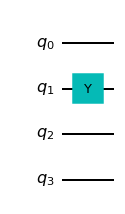

In [78]:
# from qiskit.circuit.random import random_circuit
# qc = random_circuit(3, 3, measure=False)
# qc.draw(output='mpl')

qc = QuantumCircuit(4)
# qc.x(0)
# qc.swap(0,2)
# qc.cx(1,0)
# qc.x(1)
# qc.rz(np.pi/2, 2)
# qc.rx(np.pi/2, 2)
# qc.rz(np.pi/2, 2)
# qc.cx(0,7)

# qc.cx(2,5)

# qc.cx(0,6)
qc.y(1)
# qc.cx(0,2)
qc.draw(output='mpl')

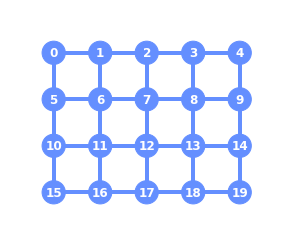

In [79]:
backend = FakeSurfaceCode(twoqubitgate="cx")
#backend = FakeHatlab()
from fakeutils.gate_map import plot_gate_map
#plot_gate_map(backend, qubit_coordinates=backend.qubit_coordinates)
plot_gate_map(backend)

Test FakeSurfaceCode topology (all to all, global ops)

1. with native gateset X,sqrtX, Y, sqrtY, RZ, CX

2. with native gateset X, sqrtX, Y, sqrtY, RZ, riSwap
    - transpile using weyl chamber
    - transpile using numerical optimization

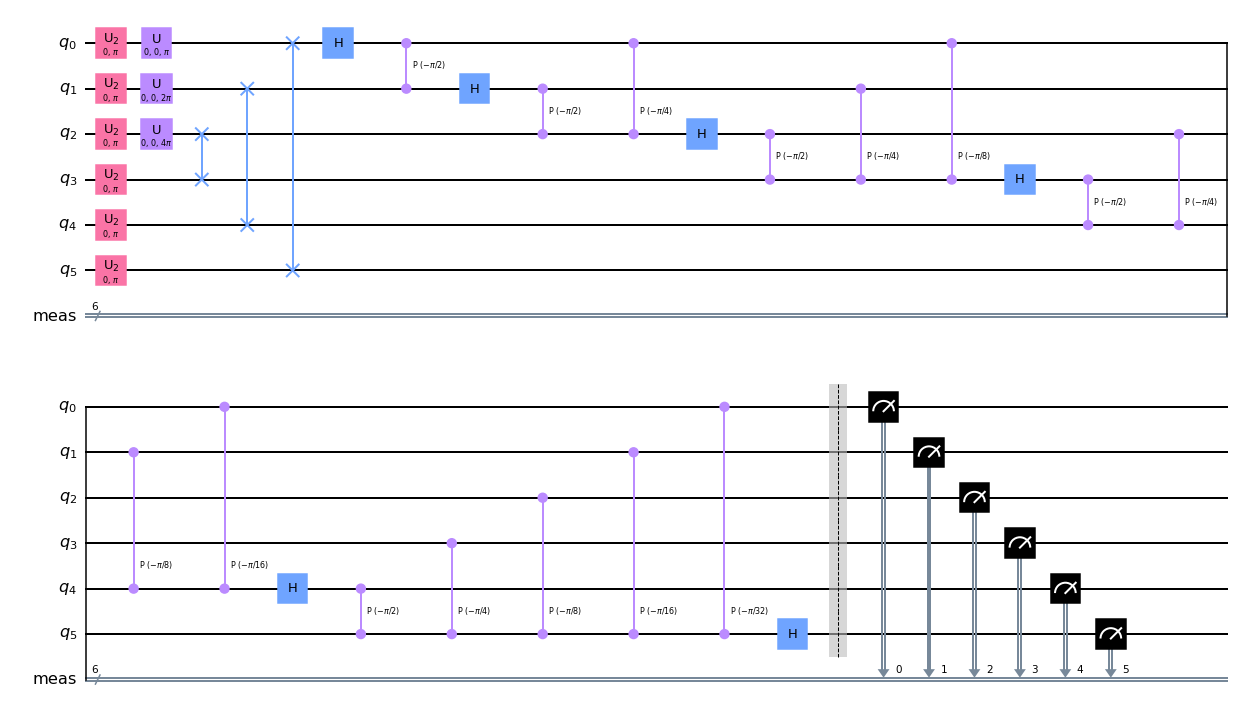

In [80]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def getQFTCircuit(nqubits=4, number=5):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    qc.p(number*np.pi/4,0)
    qc.p(number*np.pi/2,1)
    qc.p(number*np.pi,2)

    qc = inverse_qft(qc, nqubits)
    qc.measure_all()
    return qc

qc = getQFTCircuit(6,4)
qc.draw(output='mpl')

In [85]:
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.layout import Layout
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.dagcircuit import DAGCircuit
from qiskit.transpiler.layout import Layout
from qiskit.circuit.library.standard_gates import SwapGate

dag = circuit_to_dag(qc)
new_dag = dag._copy_circuit_metadata()
canonical_register = dag.qregs["q"]
trivial_layout = Layout.generate_trivial_layout(canonical_register)
current_layout = trivial_layout.copy()
for layer in dag.serial_layers():
            subdag = layer["graph"]

            for gate in subdag.two_qubit_ops():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if backend.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()
                    swap_layer.add_qreg(canonical_register)

                    path = backend.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create the swap operation
                        swap_layer.apply_operation_back(
                            SwapGate(), qargs=[qubit_1, qubit_2], cargs=[]
                        )

                    # layer insertion
                    order = current_layout.reorder_bits(new_dag.qubits)
                    new_dag.compose(swap_layer, qubits=order)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            order = current_layout.reorder_bits(new_dag.qubits)
            new_dag.compose(subdag, qubits=order)

KeyError: 'The item 6 does not exist in the Layout'

In [90]:
backend = FakeSurfaceCode(twoqubitgate="cx")
#backend = FakeHatlab()
pm = level_0_pass_manager(backend, decomp_method='cx', decompose_swaps=True, critical_path_only=False)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')

KeyError: 'u2'

Critical path duration 4.999999999999999e-08 seconds


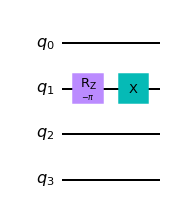

In [ ]:
backend = FakeSurfaceCode(twoqubitgate="iswap")
#backend = FakeHatlab()
pm = level_0_pass_manager(backend, decomp_method='weyl', decompose_swaps=True, critical_path_only=False)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')

Critical path duration 4.999999999999999e-08 seconds


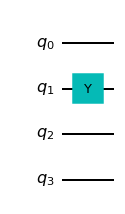

In [ ]:
backend = FakeSurfaceCode(twoqubitgate="iswap")
pm = level_0_pass_manager(backend, decomp_method='nuop', decompose_swaps=True, critical_path_only=False)
trans_circ = pm.run(qc)
print("Critical path duration", pm.property_set["duration_longest_path_length"], "seconds")
trans_circ.draw(output='mpl')